<a href="https://colab.research.google.com/github/saeu5407/multi_task_label_class/blob/main/code/multitask_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 멀티태스크 러닝(Multi-task Learning)

[Multi-Task Learning on Fate Grand Order with Keras](https://towardsdatascience.com/multi-task-learning-on-fate-grand-order-with-keras-261c5e8d3fb8)에서 공유된 멀티태스크 러닝 코드를 구현해보도록 하겠습니다.
읽기 쉽게끔 최대한 주석을 달았습니다.

데이터 및 원본 코드는 블로그에서 공유한 [깃헙 링크](https://github.com/sugi-chan/fgo-multi-task-keras)에서 확인할 수 있습니다.

### 데이터 로드 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random
from random import randrange
import cv2
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Activation, Flatten, Dropout, BatchNormalization

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

# 경로 설정(본인의)
base_path = '/content/drive/MyDrive/Git/img_multi_task/'
data_path = base_path + 'data/fgo_multitask_dataset/'

dat = pd.read_csv(data_path + 'fgo_multiclass_labels.csv', index_col=[0])

In [ ]:
print(dat.columns)
dat.head()

Index(['full_path', 'image_name', 'name', 'white', 'red', 'green', 'black',
       'blue', 'purple', 'gold', 'silver', 'gender_Female', 'gender_Male',
       'region_Asia', 'region_Egypt', 'region_Europe', 'region_Middle East',
       'fighting_type_magic', 'fighting_type_melee', 'fighting_type_ranged',
       'alignment_CE', 'alignment_CG', 'alignment_CN', 'alignment_LE',
       'alignment_LG', 'alignment_LN', 'alignment_NE', 'alignment_NG',
       'alignment_TN'],
      dtype='object')


full_path  ... alignment_TN
0  images/00a132f16df6f4e94a5d1ddf05ac2d8b.jpg  ...            0
1                    images/014 Atalante 2.png  ...            0
2                              images/0144.jpg  ...            0
3                 images/017 Cu Chulainn 4.png  ...            0
4  images/0291b4c9bde1530c3c8fac7d01c08d9a.jpg  ...            0

[5 rows x 29 columns]

full_path               images/00a132f16df6f4e94a5d1ddf05ac2d8b.jpg
image_name                     00a132f16df6f4e94a5d1ddf05ac2d8b.jpg
name                                                         jalter
white                                                             1
red                                                               1
green                                                             0
black                                                             0
blue                                                              0
purple                                                            1
gold                                                              0
silver                                                            0
gender_Female                                                     1
gender_Male                                                       0
region_Asia                                                       0
region_Egypt                                    

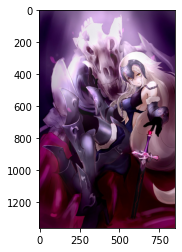

In [ ]:
# 샘플 이미지
import matplotlib.pyplot as plt
a = plt.imread(data_path + str(dat['full_path'].iloc[0]))
plt.imshow(a)
dat.iloc[0]

In [ ]:
# 라벨링 데이터프레임의 트레이닝, 테스트 데이터 세트 분할
X = dat['image_name']
y = dat[['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver', 'gender_Female',
       'gender_Male', 'region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East', 'fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged', 'alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
y_train.columns

Index(['white', 'red', 'green', 'black', 'blue', 'purple', 'gold', 'silver',
       'gender_Female', 'gender_Male', 'region_Asia', 'region_Egypt',
       'region_Europe', 'region_Middle East', 'fighting_type_magic',
       'fighting_type_melee', 'fighting_type_ranged', 'alignment_CE',
       'alignment_CG', 'alignment_CN', 'alignment_LE', 'alignment_LG',
       'alignment_LN', 'alignment_NE', 'alignment_NG', 'alignment_TN'],
      dtype='object')

In [ ]:
# Make Multi-task Training Set & Test Set
"""
각 Task에 맞게끔 트레이닝 셋 및 테스트 세트를 구성하기 위한 사전 준비 작업을 진행합니다.

구성되어 있는 Task들은 다음과 같습니다.
Task 1 : color를 구분하는 Task.
Task 2 : gender를 구분하는 Task.
Task 3 : region를 구분하는 Task.
Task 4 : fighting_style를 구분하는 Task.
Task 5 : alignment를 구분하는 Task. alignment는 게임으로 치면 진영 같은 느낌으로 보인다.
"""

# 이미지
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

# Task 1(color)
colors = ['white', 'red', 'green', 'black', 'blue', 'purple', 'gold', 'silver']
color_train = y_train[colors]
color_nodes = color_train.shape[1]
color_train = color_train.values.tolist()

# Task 2(gender)
gender = ['gender_Female',
       'gender_Male']
gender_train = y_train[gender]
gender_nodes = gender_train.shape[1]
gender_train = gender_train.values.tolist()

# Task 3(region)
region = ['region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East']
region_train = y_train[region]
region_nodes = region_train.shape[1]
region_train = region_train.values.tolist()

# Task 4(fighting_style)
fighting_style = ['fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged']
fighting_style_train = y_train[fighting_style]
fighting_nodes = fighting_style_train.shape[1]
fighting_style_train = fighting_style_train.values.tolist()

# Task 5(alignment)
alignment = ['alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']
alignment_train = y_train[alignment]
alignment_nodes = alignment_train.shape[1]
alignment_train = alignment_train.values.tolist()

print(color_nodes,gender_nodes,region_nodes,fighting_nodes,alignment_nodes)

# Test Set에 대해서도 똑같이 준비합니다.
colors = ['white', 'red',
       'green', 'black', 'blue', 'purple', 'gold', 'silver']
color_test = y_test[colors]
color_nodes = color_test.shape[1]
color_test = color_test.values.tolist()

gender = ['gender_Female',
       'gender_Male']
gender_test = y_test[gender]
gender_nodes = gender_test.shape[1]
gender_test = gender_test.values.tolist()

region = ['region_Asia', 'region_Egypt', 'region_Europe',
       'region_Middle East']
region_test = y_test[region]
region_nodes = region_test.shape[1]
region_test = region_test.values.tolist()

fighting_style = ['fighting_type_magic', 'fighting_type_melee',
       'fighting_type_ranged']
fighting_style_test = y_test[fighting_style]
fighting_nodes = fighting_style_test.shape[1]
fighting_style_test = fighting_style_test.values.tolist()

alignment = ['alignment_CE', 'alignment_CG', 'alignment_CN',
       'alignment_LE', 'alignment_LG', 'alignment_LN', 'alignment_NE',
       'alignment_NG', 'alignment_TN']
alignment_test = y_test[alignment]
alignment_nodes = alignment_test.shape[1]
alignment_test = alignment_test.values.tolist()

print(color_nodes,gender_nodes,region_nodes,fighting_nodes,alignment_nodes)

8 2 4 3 9
8 2 4 3 9


In [ ]:
# 참고할만한 점
# color는 multi-label.
color_train[:3]

[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

In [ ]:
# initialize the number of epochs and batch size
EPOCHS = 50
BS = 16

# image_generator_fgo라는 함수를 통해 전처리를 진행합니다.
"""
이미지와 각 레이블을 담을 리스트를 준비한 후,
"""
def image_generator_fgo(king_of_lists, bs, mode="train", aug=None):
    # loop indefinitely
    
    while True:
        # 이미지와 각 레이블을 담을 리스트
        images = []
        color = []
        gender = []
        region = []
        fight = []
        alignment = []
        
        # 이미지의 수가 배치 사이즈보다 작을 동안 루프문을 진행
        while len(images) < bs:
            combined_label_list = []

            # 랜덤하게 이미지를 뽑아서, 관련된 Task의 레이블들과 리스트로 적재하는 구문
            # 랜덤 이미지 로드
            random_index = randrange(len(king_of_lists[0]))
            img = image.load_img(data_path+'images/'+king_of_lists[0][random_index],target_size=(224, 224)) #read in image
            img = image.img_to_array(img)
            img = preprocess_input(img)
            
            # 이미지와 관련 Task들의 레이블 append
            gender.append(king_of_lists[1][random_index]) # gender
            region.append(np.array(king_of_lists[2][random_index])) # region
            fight.append(np.array(king_of_lists[3][random_index])) # fighting
            alignment.append(np.array(king_of_lists[4][random_index])) # alignment
            color.append(np.array(king_of_lists[5][random_index])) # color
            images.append(img) # image
            
        # 최종 리스트 저장
        labels = [np.array(gender),np.array(region),np.array(fight),np.array(alignment), np.array(color)]

        # aug는 밖에서 ImageDataGenerator를 불러오는 파라미터로 사용합니다. 다만 뒤의 함수에서 None으로 지정
        if aug is not None:
            (images, labels) = next(aug.flow(np.array(images),labels, batch_size=bs))
        
        # 이터레이터
        yield np.array(images), labels
        """
        yield는 제너레이터에 사용되는 키워드로,
        반복문과 사용하는 return 구문이라고 볼 수 있습니다.
        """

# 함수에 사용되는 이미지 제너레이터 부분
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# 함수에 넣기 위해 이미지Path, 각 레이블Path를 리스트화
train_lists = [X_train, gender_train, region_train, fighting_style_train, alignment_train, color_train]
test_lists = [X_test, gender_test, region_test, fighting_style_test, alignment_test, color_test]

# Train, Test set에 대해 함수 실행
trainGen = image_generator_fgo(train_lists, BS, 
                               mode="train", aug=None)
testGen = image_generator_fgo(test_lists, BS, 
                              mode="train", aug=None)

### 모델 구현 및 훈련

In [ ]:
# Color Images, Multi-Label Targets
from tensorflow.keras.optimizers import SGD

# Loss, Metric 설정
loss_list = ["categorical_crossentropy",'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','binary_crossentropy']
test_metrics = {'gender': 'accuracy','region': 'accuracy','fighting_style': 'accuracy','alignment': 'accuracy','color': 'accuracy'}

dd = 0.0 # Dropout 부분
import math

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

# Multi-task 모델 구현부
"""
Shared layer(컨볼루전 망)에 대해서는 VGG19를 전이학습하여 사용하고(가중치 업데이트 freeze),
이후 GAP를 적용한 값들에 대해 Task별로 별도의 레이어를 구성하는 방식으로 구현.
"""
def multi_model(loss_list,test_metrics,dd):
    
    # 모든 Task들이 공유하는 컨볼루전망
    # VGG19 전이학습 수행
    base_model = VGG19(weights='imagenet', include_top=False)

    # VGG19의 가중치 업데이트 freeze
    for layer in base_model.layers[:]:
       layer.trainable = False

    # 이미지 input 및 Shared parameter 부분
    model_input = Input(shape=(224, 224, 3))
    x = base_model(model_input) # VGG19
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)

    # Task 1의 Layer
    y1 = Dense(128, activation='relu')(x)
    y1 = Dropout(dd)(y1)
    y1 = Dense(64, activation='relu')(y1)
    y1 = Dropout(dd)(y1)
    
    # Task 2의 Layer
    y2 = Dense(128, activation='relu')(x)
    y2 = Dropout(dd)(y2)
    y2 = Dense(64, activation='relu')(y2)
    y2 = Dropout(dd)(y2)
    
    # Task 3의 Layer
    y3 = Dense(128, activation='relu')(x)
    y3 = Dropout(dd)(y3)
    y3 = Dense(64, activation='relu')(y3)
    y3 = Dropout(dd)(y3)

    # Task 4의 Layer
    y4 = Dense(128, activation='relu')(x)
    y4 = Dropout(dd)(y4)
    y4 = Dense(64, activation='relu')(y4)
    y4 = Dropout(dd)(y4)
    
    # Task 5의 Layer
    y5 = Dense(128, activation='relu')(x)
    y5 = Dropout(dd)(y5)
    y5 = Dense(64, activation='relu')(y5)
    y5 = Dropout(dd)(y5)
    
    # 각 Task별 최종 Dense 연결
    y1 = Dense(gender_nodes, activation='softmax',name= 'gender')(y1)
    y2 = Dense(region_nodes, activation='softmax',name= 'region')(y2)
    y3 = Dense(fighting_nodes, activation='softmax',name= 'fighting_style')(y3)
    y4 = Dense(alignment_nodes, activation='softmax',name= 'alignment')(y4)
    y5 = Dense(color_nodes, activation='sigmoid',name= 'color')(y5)
    
    # 공유 파라미터와 각 Task 연결
    model = Model(inputs=model_input, outputs=[y1, y2, y3, y4, y5])
    
    # 컴파일러 부분
    model.compile(loss=loss_list, optimizer=SGD(lr=0.01, momentum=0.9), metrics=test_metrics)

    return model

multi_model = multi_model(loss_list,test_metrics,dd)
multi_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          131328      global_average_pooling2d[0][0]   
_____________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print(multi_model.metrics_names)

[]


In [ ]:
checkpoint = ModelCheckpoint(data_path + 'best_run5_smaller.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lrate = LearningRateScheduler(step_decay)
callbacks_list = [checkpoint,lrate]
multi_model.fit_generator(trainGen,steps_per_epoch=len(X_train) // BS,
                    validation_data=testGen,
                    validation_steps=len(X_test) // BS,
                    epochs=EPOCHS, callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
22/22 [==============================] - 68s 3s/step - loss: 7.6059 - gender_loss: 1.1001 - region_loss: 1.7852 - fighting_style_loss: 1.5628 - alignment_loss: 2.4313 - color_loss: 0.7266 - gender_accuracy: 0.5369 - region_accuracy: 0.4659 - fighting_style_accuracy: 0.3949 - alignment_accuracy: 0.2472 - color_accuracy: 0.1250 - val_loss: 5.2683 - val_gender_loss: 0.5828 - val_region_loss: 1.0265 - val_fighting_style_loss: 1.0666 - val_alignment_loss: 1.9720 - val_color_loss: 0.6203 - val_gender_accuracy: 0.8125 - val_region_accuracy: 0.7188 - val_fighting_style_accuracy: 0.5312 - val_alignment_accuracy: 0.1250 - val_color_accuracy: 0.0938

Epoch 00001: val_loss improved from inf to 5.26827, saving model to /content/drive/MyDrive/Git/Image_Multitask/data/fgo_multitask_dataset/best_run5_smaller.h5
Epoch 2/50
22/22 [==============================] - 30s 1s/step - loss: 4.9430 - gender_loss: 0.6160 - region_loss: 1.0450 - fighting_style_loss: 0.8506 - alignment_loss: 1.8017 - co

### 테스트

In [ ]:
# 최종 저장 모델 불러오기
model = load_model(data_path + 'best_run5_smaller.h5')

img = image.load_img(data_path + 'test/saber1.jpg',target_size=(224, 224)) #read in image
img = image.img_to_array(img)
img = preprocess_input(img)
prediction = model.predict(np.array([img]))

Female
Europe
melee
LG
['gold', 'silver', 'blue']


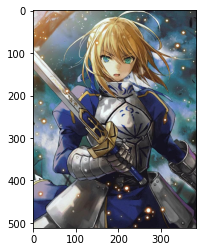

In [ ]:
# 결과에 따라 레이블을 뽑이주는 함수 구현
def extract_label(label_list, pred_array):
    pred_max = pred_array.argmax()
    
    return label_list[pred_max]

# 요부분은 color에 대해서는 multiclass가 아닌 multilabel로 구현되어 있어서 이렇게 작업한듯
def extract_top_3(label_list, pred_array):
    max_ = pred_array.argsort()[0][-1]
    second_ = pred_array.argsort()[0][-2]
    third_ = pred_array.argsort()[0][-3]
    
    return [label_list[max_],label_list[second_],label_list[third_]]
    
gender = ['Female','Male']
region = ['Asia', 'Egypt', 'Europe','Middle East']
fighting_style = ['magic', 'melee','ranged']
alignment = ['CE', 'CG', 'CN','LE', 'LG', 'LN', 'NE','NG', 'TN']
colors = ['white', 'red','green', 'black', 'blue', 'purple', 'gold', 'silver']


print(extract_label(gender, prediction[0]))
print(extract_label(region, prediction[1]))
print(extract_label(fighting_style, prediction[2]))
print(extract_label(alignment, prediction[3]))
print(extract_top_3(colors, prediction[4]))
im2 = image.load_img(data_path + 'test/saber1.jpg')
plt.imshow(im2)

692882.jpg

image:  692882.jpg
Female
Middle East
ranged
LG
['gold', 'white', 'blue']


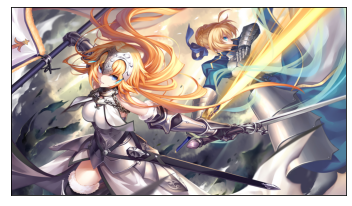

arturia1.png

image:  arturia1.png
Female
Europe
melee
NE
['black', 'gold', 'blue']


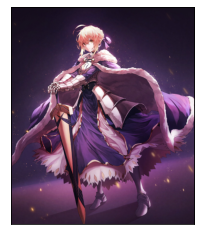

0defe15146155708d28195cff615d18b--ears-anime-art.jpg

image:  0defe15146155708d28195cff615d18b--ears-anime-art.jpg
Female
Europe
ranged
NE
['black', 'green', 'gold']


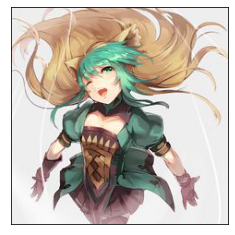

anime-fatestay-night-49204.jpg

image:  anime-fatestay-night-49204.jpg
Female
Egypt
magic
LG
['gold', 'blue', 'white']


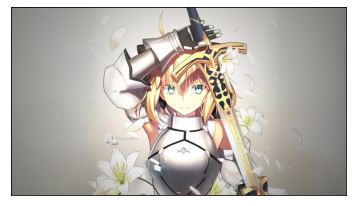

arthur1.jpg

image:  arthur1.jpg
Female
Europe
melee
LG
['silver', 'gold', 'white']


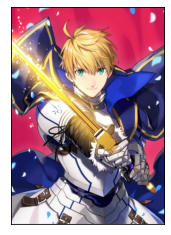

ishtar3.png

image:  ishtar3.png
Male
Europe
ranged
LG
['blue', 'black', 'gold']


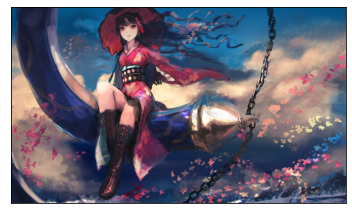

331453-Fate_Series-Saber_Lily-748x1008.png

image:  331453-Fate_Series-Saber_Lily-748x1008.png
Female
Asia
melee
NE
['blue', 'white', 'gold']


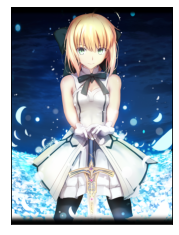

gilgamesh.png

image:  gilgamesh.png
Female
Egypt
magic
LG
['gold', 'blue', 'white']


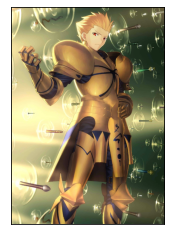

arthur2.jpg

image:  arthur2.jpg
Female
Europe
melee
LG
['purple', 'white', 'gold']


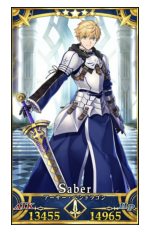

jalter3.jpg

image:  jalter3.jpg
Female
Middle East
melee
CE
['black', 'blue', 'purple']


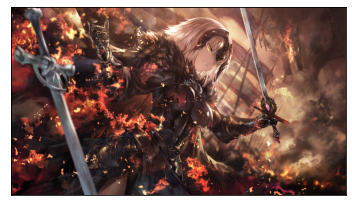

gilgamesh2.jpg

image:  gilgamesh2.jpg
Female
Europe
melee
LG
['gold', 'white', 'purple']


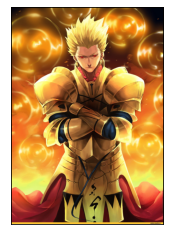

gilgamesh3.jpg

image:  gilgamesh3.jpg
Female
Asia
melee
CG
['red', 'gold', 'black']


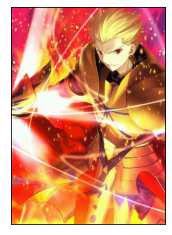

jalter2.jpg

image:  jalter2.jpg
Female
Europe
melee
CE
['black', 'purple', 'red']


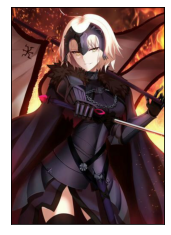

ishtar2.jpg

image:  ishtar2.jpg
Male
Europe
ranged
LG
['silver', 'green', 'black']


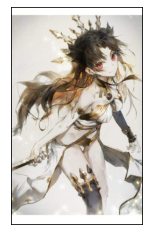

jalter5.jpg

image:  jalter5.jpg
Male
Europe
melee
CE
['red', 'black', 'purple']


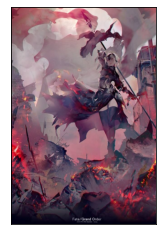

larturia.png

image:  larturia.png
Female
Europe
melee
LG
['blue', 'white', 'silver']


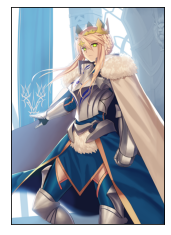

jeanne.jpg

image:  jeanne.jpg
Female
Middle East
ranged
LG
['gold', 'white', 'black']


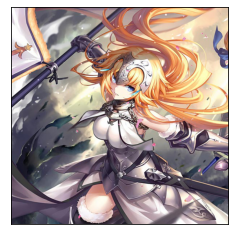

ishtar1.jpg

image:  ishtar1.jpg
Male
Middle East
ranged
LE
['black', 'red', 'gold']


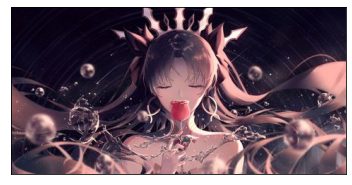

images.jpg

image:  images.jpg
Female
Europe
melee
CN
['red', 'black', 'blue']


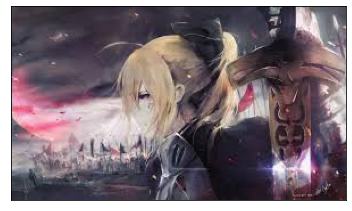

inho-song-fate-fate-grand-order-saber-artoria-pendragon-devu.jpg

image:  inho-song-fate-fate-grand-order-saber-artoria-pendragon-devu.jpg
Female
Europe
melee
LE
['black', 'silver', 'gold']


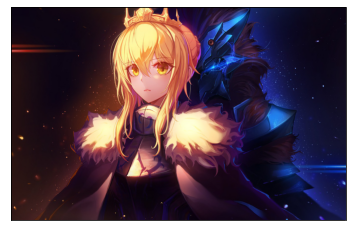

jalter4.jpg

image:  jalter4.jpg
Male
Europe
melee
CE
['red', 'black', 'gold']


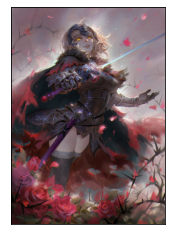

gilgamesh4.jpg

image:  gilgamesh4.jpg
Male
Asia
ranged
LG
['gold', 'white', 'blue']


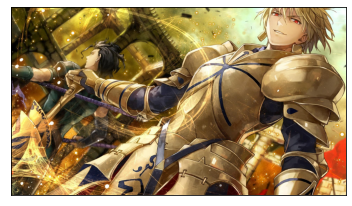

ishtar4.jpg

image:  ishtar4.jpg
Female
Europe
ranged
NE
['gold', 'black', 'silver']


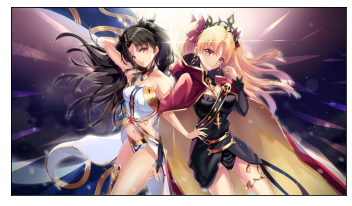

jalter1.jpg

image:  jalter1.jpg
Female
Europe
melee
LE
['black', 'silver', 'red']


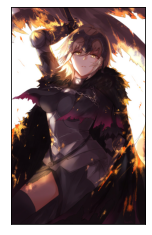

musashi4.jpg

image:  musashi4.jpg
Female
Europe
melee
CG
['red', 'purple', 'black']


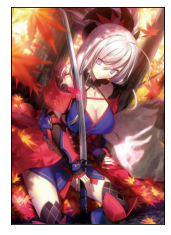

merlin.png

image:  merlin.png
Male
Europe
magic
NE
['blue', 'gold', 'white']


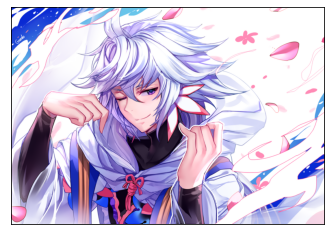

morderd2.jpg

image:  morderd2.jpg
Female
Europe
melee
CN
['red', 'white', 'purple']


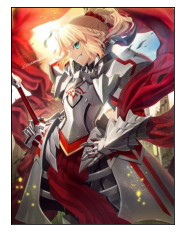

musashi2.jpg

image:  musashi2.jpg
Female
Asia
magic
CG
['gold', 'white', 'red']


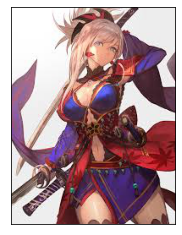

musashi3.jpg

image:  musashi3.jpg
Female
Middle East
melee
CG
['red', 'gold', 'purple']


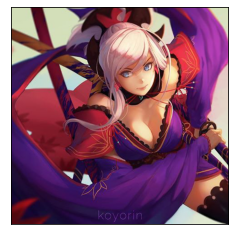

musashi.jpg

image:  musashi.jpg
Female
Europe
melee
CE
['red', 'purple', 'black']


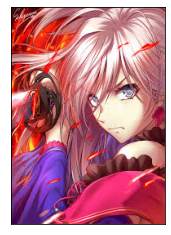

okita2.jpg

image:  okita2.jpg
Female
Asia
melee
TN
['white', 'blue', 'black']


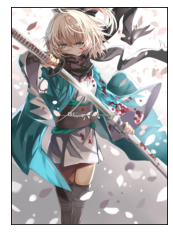

ozy.jpg

image:  ozy.jpg
Male
Egypt
magic
CN
['gold', 'white', 'blue']


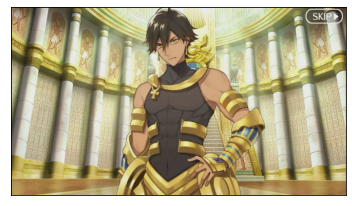

morderd3.jpg

image:  morderd3.jpg
Female
Europe
melee
CE
['red', 'black', 'purple']


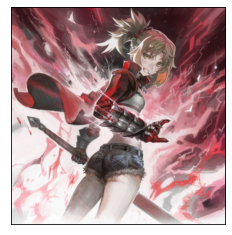

Saber.(Fate.stay.night).600.2105628.jpg

image:  Saber.(Fate.stay.night).600.2105628.jpg
Male
Europe
magic
LG
['white', 'gold', 'blue']


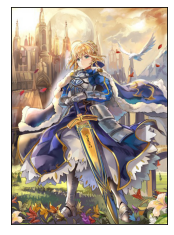

okita.jpg

image:  okita.jpg
Male
Asia
magic
LN
['blue', 'white', 'green']


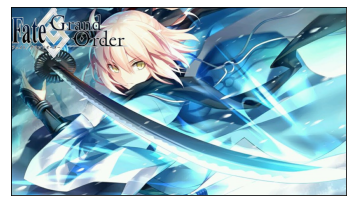

morderd1.png

image:  morderd1.png
Female
Asia
melee
CE
['black', 'purple', 'red']


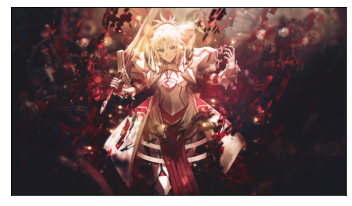

saber15th.jpg

image:  saber15th.jpg
Female
Asia
melee
LG
['blue', 'gold', 'white']


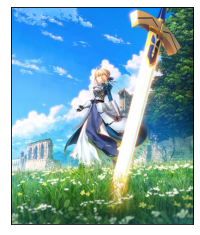

saber1.jpg

image:  saber1.jpg
Female
Europe
melee
LG
['gold', 'silver', 'blue']


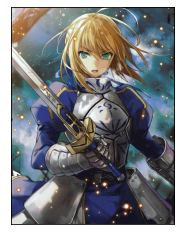

Saber.(Fate.stay.night).full.1847202.jpg

image:  Saber.(Fate.stay.night).full.1847202.jpg
Male
Europe
melee
LG
['gold', 'white', 'red']


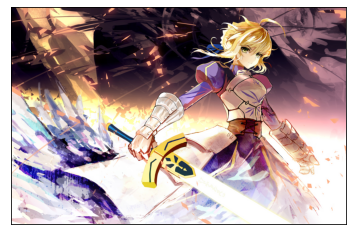

saber2.jpg

image:  saber2.jpg
Female
Asia
ranged
NE
['white', 'gold', 'blue']


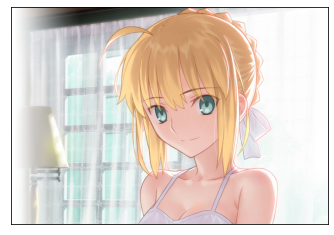

wlop.jpg

image:  wlop.jpg
Male
Middle East
ranged
LG
['gold', 'white', 'red']


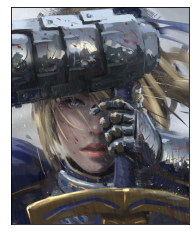

saber-fate-background-5.png

image:  saber-fate-background-5.png
Female
Europe
melee
LG
['gold', 'blue', 'white']


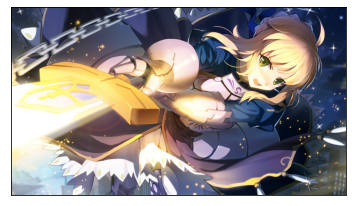

sablia-seinen-devushka-arturiia-pendragon-anime-alter-sudb-1.jpg

image:  sablia-seinen-devushka-arturiia-pendragon-anime-alter-sudb-1.jpg
Female
Asia
melee
CE
['blue', 'black', 'purple']


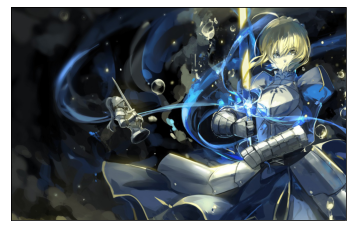

sablia-seinen-devushka-arturiia-pendragon-anime-alter-sudb-2.jpg

image:  sablia-seinen-devushka-arturiia-pendragon-anime-alter-sudb-2.jpg
Female
Asia
melee
LG
['blue', 'white', 'gold']


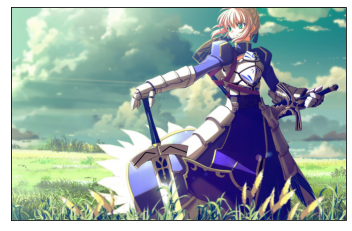

saber3.jpg

image:  saber3.jpg
Male
Europe
ranged
LG
['blue', 'gold', 'green']


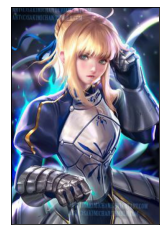

umu1.jpg

image:  umu1.jpg
Male
Middle East
ranged
LG
['gold', 'red', 'blue']


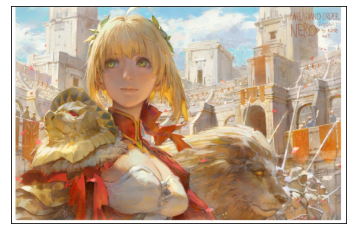

stheno.jpg

image:  stheno.jpg
Male
Asia
ranged
LN
['white', 'blue', 'gold']


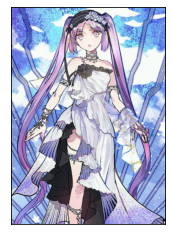

santaalter.jpg

image:  santaalter.jpg
Female
Europe
melee
CE
['white', 'gold', 'silver']


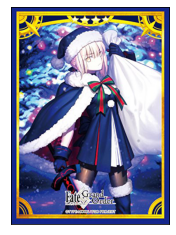

Saber.(Fate.stay.night).full.2219014.jpg

image:  Saber.(Fate.stay.night).full.2219014.jpg
Female
Europe
melee
LG
['silver', 'gold', 'blue']


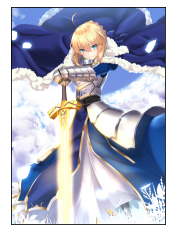

saber4.png

image:  saber4.png
Female
Middle East
melee
LE
['black', 'blue', 'purple']


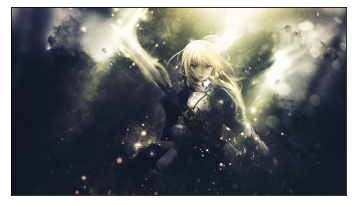

scattach.png

image:  scattach.png
Female
Europe
melee
CE
['black', 'purple', 'red']


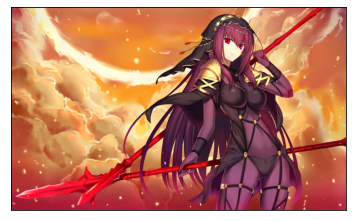

In [ ]:
# testset에 대해 모두 실행
from os import listdir

test = listdir(data_path + 'test/')
    
for i in test:
    img = image.load_img(data_path+'test/'+i,target_size=(224, 224)) #read in image
    img = image.img_to_array(img)
    img = preprocess_input(img)
    prediction = model.predict(np.array([img]))
    print(i)
    
    
    print('')
    print('image: ', i )
    print(extract_label(gender, prediction[0]))
    print(extract_label(region, prediction[1]))
    print(extract_label(fighting_style, prediction[2]))
    print(extract_label(alignment, prediction[3]))
    print(extract_top_3(colors, prediction[4]))
    
    im2 = image.load_img(data_path + 'test/'+i)
    plt.imshow(im2)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()